<h2><center>Aprendizado de Máquina - Projeto Final</center></h2>
<h2><center>Problemas de Classificação - Implementação de um Algoritmo Knn</center></h2>

<h4><center>Otávio de Meira Lima - 2019054900</center></h4>

O trabalho proposto nesse projeto foi resolver problemas de classificação por meio de uma implementação própria de um algoritmo conhecido como K-nearest neighbors. Ao longo do projeto, foram implementadas todos os métodos em que tradicionalmente se utiliza bibliotecas com métodos prontos, como a separação dos dados em treino e teste, implementação completa de uma Estrutura de Dados denominada Árvore K-d, métodos para treinar e até mesmo para avaliar o modelo por meio de métricas tradicionais. Após a avaliação do modelo, os classificadores tradicionais da biblioteca scikitlearn foram utilizados para comparar o quão eficaz é o modelo implementado.

Apesar de que todos os métodos tradicionais foram implementados, é necessário realizar sua importação das bibliotecas do Python para que todo o processo de comparação seja separado entre métodos e modelos de implementação própria e métodos de biblioteca.

In [390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import random
import heapq
from statistics import mode
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier

A seguir, foram implementadas todos os métodos necessários para leitura e manipulação dos dados.
</br>
</br>
O primeiro método, getDataPoints, recebe o nome do arquivo e retorna os pontos de maneira padronizada. Todos os pontos devem ser padronizados como float para possibilitar a realização de cálculos durante a construção e treinamento da árvore Kd.
O método seguinte, getDimensions, simplesmente retorna a quantidade de dimensões dos dados presentes. Isso pode ser resolvido também por meio do atributo db.shape.
</br>
</br>
O método getTrainingAndTestsPoints recebe os dados e os divide em dados de treino e teste em uma proporção 70-30. A lista de dados é embaralhada e os primeiros 70% dos dados se tornam dados de treino e o restante são dados de teste. Essa é a implementação do método 'train_test_split' da biblioteca sklearn.model_selection.
</br>
</br>
O método getUniqueClasses retorna a quantidade de classificações possíveis existem para os dados. Apenas a primeira será considerada a classificação positiva quando métricas estiverem sendo calculadas. Esse método pode ser facilmente implementado por meio de métodos nativos do python, como len(set(class_list)).

In [391]:
def getDataPoints(filename):
    data = np.loadtxt(filename, delimiter=',', dtype=str)

    listofpoints = []

    for d in data:
        listofpoints.append(tuple(d))

    ans = []
    for tupl in listofpoints:
        temp = []
        for x in tupl:
            try:
                temp.append(float(x))
            except Exception:
                temp.append(x)
        ans.append(tuple(temp))

    return ans

def getDimensions(data):
    return len(data[0])

def getTrainingAndTestsPoints(data):

    seventyPercent = int((70/100)*len(data))
    random.shuffle(data)

    trainingPoints = data[:seventyPercent]
    testPoints = data[seventyPercent + 1:]

    return trainingPoints, testPoints

def getUniqueClasses(data):
    classes = []
    dimension = getDimensions(data)

    for p in data:
        if classes.count(p[dimension-1]) == 0:
            classes.append(p[dimension-1])

    return classes

Ná célula a seguir está implementada a árvore K-d. Essa é uma estrutura de dados bem única, já que consegue dividir os dados em qualquer espaço por meio de uma árvore binária. 

In [392]:
class Node():
    def __init__(self, value, left, right):
        self.value = value
        self.left = left
        self.right = right

def printPreorder(node):

    if node:
        print(node.value)
        printPreorder(node.left)
        printPreorder(node.right)

def kdtree(point_list, depth=0):
    try:
        k = len(point_list[0]) - 1
    except IndexError as e:
        return None

    if len(point_list) == 1:
        return Node(value=point_list[0],left=None,right=None)

    axis = depth % k

    point_list.sort(key=lambda x: x[axis])
    
    l = len(point_list)
    if l%2 == 0:
        median = int((l/2)-1)
    else:
        median = l // 2

    return Node(
        value=point_list[median][axis],
        left=kdtree(point_list[:median+1], depth + 1),
        right=kdtree(point_list[median + 1:], depth + 1)
    )
class Kdtree():

    def buildKdtree(point_list):
        return kdtree(point_list)



In [393]:
def euclideanDistance(a, b):
    return np.linalg.norm(np.asarray(a)-np.asarray(b))

def k_nearestAux(dimensions, k, point, current_node, priority_queue=[], depth=0):

    axis = depth % (dimensions-1)
    depth += 1

    if current_node.left == None and current_node.right == None:
        distance = euclideanDistance(point[:dimensions-1], current_node.value[:dimensions-1])
        if len(priority_queue) < k:
            heapq.heappush(priority_queue, (-distance,current_node.value))
            priority_queue = sorted(priority_queue)

        elif -distance < -priority_queue[0][0]:
            heapq.heappushpop(priority_queue, (-distance, current_node.value))
            priority_queue = sorted(priority_queue)

        return priority_queue

    else:

        if point[axis] > current_node.value:
            nearBranch = current_node.right
            opositeBranch = current_node.left
        else:
            nearBranch = current_node.left
            opositeBranch = current_node.right

        priority_queue = k_nearestAux(dimensions, k, point, nearBranch, priority_queue, depth)

        if len(priority_queue) < k or priority_queue[0][1][axis] <= abs(point[axis] - current_node.value):

            priority_queue = k_nearestAux(dimensions, k, point, opositeBranch, priority_queue, depth)

        return priority_queue

class Xnn():

    def __init__(self, priority_queue):
        self.priority_queue = priority_queue
        self.kdtree = None

    def buildKdtree(self, point_list):
        self.kdtree = Kdtree.buildKdtree(point_list)

    def k_nearest(self, dimensions, k, point, current_node):
        self.priority_queue = k_nearestAux(dimensions, k, point, current_node, self.priority_queue, depth=0)

    def getClassificationFromPQ(self, dimensions):
        temp = []
        for p in self.priority_queue:
            temp.append(p[1][dimensions-1])

        return mode(temp)

    def getStatisticsFromTestPoints(self, k, test_point_list, classifications):
        
        tp = fp = tn = fn = 0
        dimensions = getDimensions(test_point_list)
        i = 0
        for point in test_point_list:
            self.k_nearest(dimensions, k, point, self.kdtree)
            classification = self.getClassificationFromPQ(dimensions)
            if point[dimensions-1] == classifications[0]:
                if classification == point[dimensions-1]:
                    tp += 1
                else:
                    fn += 1
            else:
                if classification == point[dimensions-1]:
                    tn += 1
                else:
                    fp += 1
        try:            
            precision = tp/(tp + fp) * 100
            revocation = tp/(tp+fn) * 100
            accuracy = (tp+tn)/(tp+tn+fp+fn) * 100
        except ZeroDivisionError:
            precision = revocation = 0
            accuracy = (tp+tn)/(tp+tn+fp+fn) * 100

        return accuracy, revocation, precision

In [394]:
acc = []
recc = []
prec = []

naive_bayes_model = GaussianNB()
decision_tree_model = DecisionTreeClassifier(max_depth=7)
svm_model = svm.SVC(kernel='rbf')
knn_model = KNeighborsClassifier(n_neighbors=5)
random_forest_model = RandomForestClassifier(n_estimators=5)
gradient_tree_boosting = GradientBoostingClassifier(n_estimators=4)
lgbmc_model = LGBMClassifier()

models = [naive_bayes_model, decision_tree_model, svm_model, random_forest_model, gradient_tree_boosting, knn_model, lgbmc_model]
models_name = ['Naive Bayes', 'Decision Tree', 'SVM', 'Random Forest', 'Gradient Tree Boosting', 'KNN', 'LGBMC', 'Xnn Implelentation']

def getSklearnStatisticsFromTestPoints(X_train, X_test, y_train, y_test):

    for i in range(len(models)):
        model = models[i].fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Modelo: ", models_name[i])
        acuraccy = metrics.accuracy_score(y_test, y_pred, normalize=True) * 100
        acc.append(acuraccy)
        recall = metrics.recall_score(y_test, y_pred, average='macro', zero_division=1) * 100
        recc.append(recall)
        precision = metrics.precision_score(y_test, y_pred, average='macro', zero_division=1) * 100
        prec.append(precision)

    return acc, recc, prec 

In [395]:
def run(database):

    #run my implementation of Xnn
    print('Database: ' + database)
    point_list = getDataPoints('data/' + database + '.csv')
    trainingPoints, testPoints = getTrainingAndTestsPoints(point_list)

    xnn = Xnn(priority_queue=[])
    xnn.buildKdtree(trainingPoints)
    accuracy, revocation, precision = xnn.getStatisticsFromTestPoints(5, testPoints, getUniqueClasses(testPoints))

    #run sklearn models
    df = pd.read_csv('data/' + database + '.csv')
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    acc, recc, prec = getSklearnStatisticsFromTestPoints(X_train, X_test, y_train, y_test)

    acc.append(accuracy)
    recc.append(revocation)
    prec.append(precision)

    plt.figure(figsize=(20,10))
    plt.title(database + " - results")
    plt.xlabel("Models")
    plt.ylabel("%")
    plt.plot(acc, label = 'Accuracy')
    plt.plot(recc, label = 'Revocation')
    plt.plot(prec, label = 'Precision')
    plt.xticks(range(len(acc)), models_name)
    plt.legend()
    plt.show()

    acc.clear()
    prec.clear()
    recc.clear()
    

Database: glassClassification
Modelo:  Naive Bayes
Modelo:  Decision Tree
Modelo:  SVM
Modelo:  Random Forest
Modelo:  Gradient Tree Boosting
Modelo:  KNN
Modelo:  LGBMC


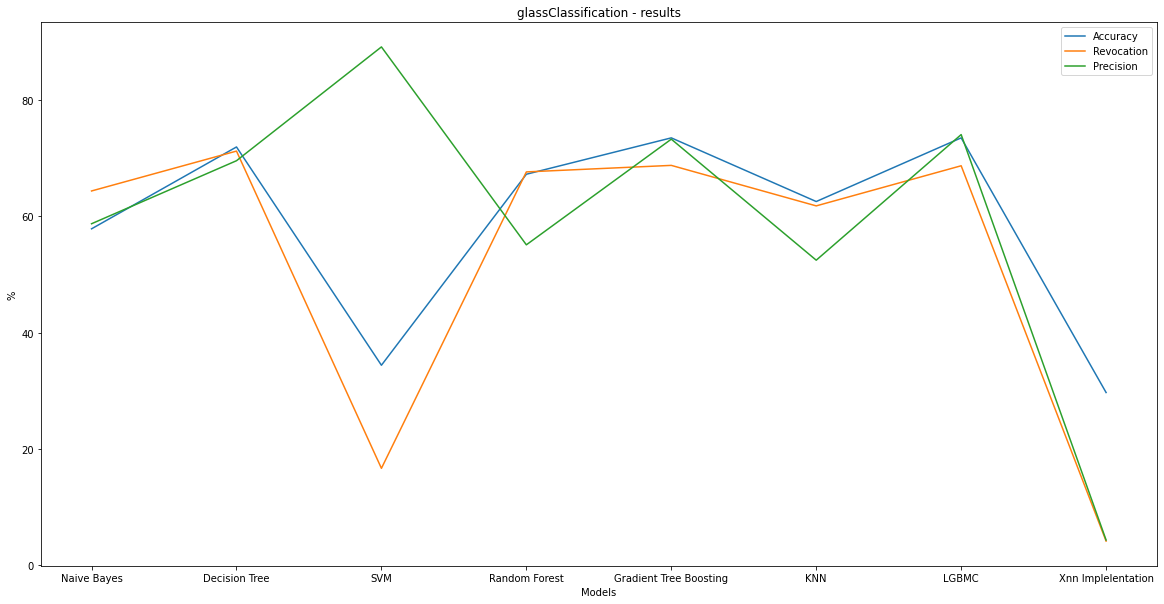

In [396]:
run('glassClassification')

Database: drugClassification
Modelo:  Naive Bayes
Modelo:  Decision Tree
Modelo:  SVM
Modelo:  Random Forest
Modelo:  Gradient Tree Boosting
Modelo:  KNN
Modelo:  LGBMC


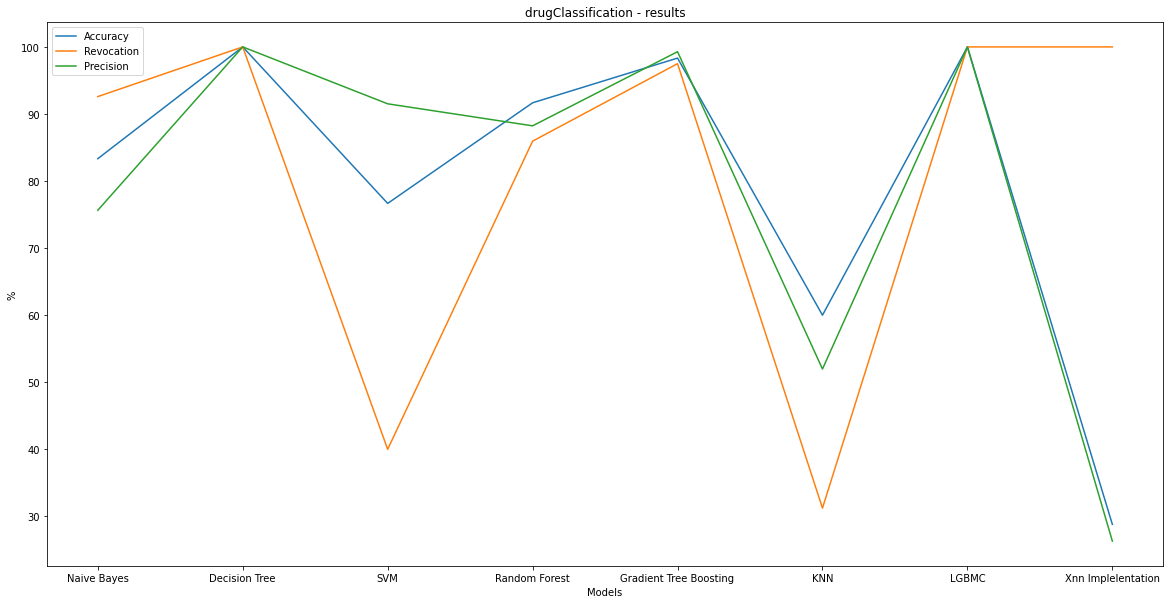

In [397]:
run('drugClassification')
